Best Hyperparameters: {'classifier__C': 1, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}

Confusion Matrix:
[[ 802  440]
 [ 273 1835]]

Classification Report:
              precision    recall  f1-score   support

       False       0.75      0.65      0.69      1242
        True       0.81      0.87      0.84      2108

    accuracy                           0.79      3350
   macro avg       0.78      0.76      0.76      3350
weighted avg       0.78      0.79      0.78      3350



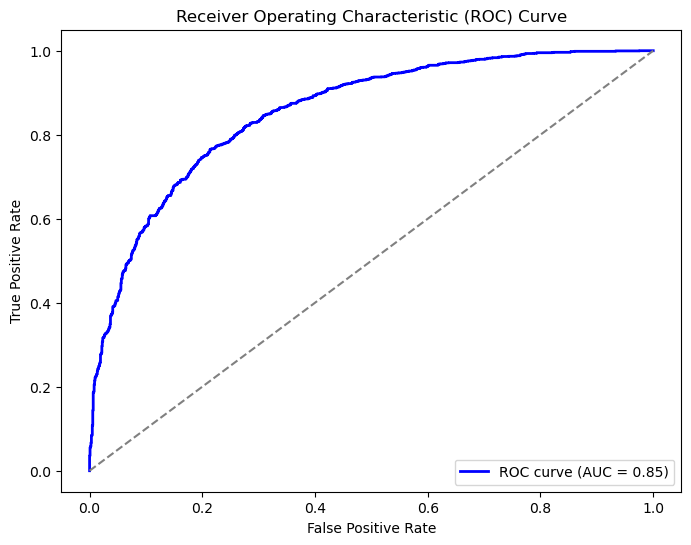

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import warnings
import pickle

# Filter out any warnings
warnings.filterwarnings("ignore")

# Step 1: Read the cleaned dataset
df_cleaned = pd.read_csv('cleaned_dataset1.csv')

# Step 1.1: Drop non-numeric columns if needed
df_cleaned.drop(columns=['Booking_ID'], inplace=True)

# Step 2: Split the dataset into features (X) and target variable (y)
X = df_cleaned.drop(columns=['booking_status_Not_Canceled'])
y = df_cleaned['booking_status_Not_Canceled']

# Step 3: Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 4: Define preprocessing steps if needed

# Step 5: Initialize the Logistic Regression classifier
logistic_regression = LogisticRegression()

# Step 6: Create the pipeline if needed
pipeline = Pipeline(steps=[
    ('classifier', logistic_regression)
])

# Step 7: Define the hyperparameters grid
param_grid = {
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],  # Regularization parameter
    'classifier__penalty': ['l1', 'l2'],                # Regularization penalty
    'classifier__solver': ['liblinear', 'saga']         # Solver for optimization problem
}

# Step 8: Initialize Grid Search with cross-validation
grid_search = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='accuracy')

# Step 9: Fit the Grid Search to the training data
grid_search.fit(X_train, y_train)

# Step 10: Get the best hyperparameters and best model
best_params = grid_search.best_params_
best_model = grid_search.best_estimator_

# Step 11: Make predictions on the testing data using the best model
y_pred = best_model.predict(X_test)

# Step 12: Evaluate the best model
print("Best Hyperparameters:", best_params)
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Step 13: Pickle the Logistic Regression model for deployment
with open('logistic_regression_best_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Step 14: Plot ROC curve
if hasattr(best_model.named_steps['classifier'], 'predict_proba'):
    # Predict probabilities for the positive class
    y_prob = best_model.named_steps['classifier'].predict_proba(X_test)[:, 1]  # Probability of class 1 (canceled bookings)

    # Compute ROC curve
    fpr, tpr, thresholds = roc_curve(y_test, y_prob)

    # Calculate AUC
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
else:
    print("ROC curve cannot be plotted as the classifier does not support predict_proba method.")